In [1]:
import subprocess
subprocess.check_output(["maturin", "develop"])
import time

🍹 Building a mixed python/rust project
🔗 Found pyo3 bindings
🐍 Found CPython 3.10 at /home/wint3rmute/code/luthier/.venv/bin/python
📡 Using build options features from pyproject.toml
   --> src/ladder_filter.rs:132:8
    |
110 | impl LadderFilter {
    | ----------------- method in this implementation
...
132 |     fn run_ladder_nonlinear(&mut self, input: f64) {
    |        ^^^^^^^^^^^^^^^^^^^^
    |
    = note: `#[warn(dead_code)]` on by default

    Finished dev [unoptimized + debuginfo] target(s) in 0.04s
⚠️ Warning: Failed to set rpath for /home/wint3rmute/code/luthier/target/debug/libluthier.so: Failed to execute 'patchelf', did you install it? Hint: Try `pip install maturin[patchelf]` (or just `pip install patchelf`)
📦 Built wheel for CPython 3.10 to /tmp/.tmp5td5Vy/luthier-0.1.0-cp310-cp310-linux_x86_64.whl
🛠 Installed luthier-0.1.0


In [2]:
from luthier.luthier import DspGraph, SineOscillator, HighPassFilter, Delay, Chorus, Multiplier, HarmonicMultiplier, Sum, ADSR, LowPassFilter, SquareOscillator, Reverb, SawOscillator, TriangleOscillator
from IPython.display import Audio, display, Image, HTML
from luthier.dsp import Sample, SAMPLE_RATE, DspGraphOptimizer
import matplotlib.pyplot as plt
from multiprocessing import Pool
import librosa
import soundfile as sf
from tqdm.notebook import tqdm
from scipy.optimize import differential_evolution
import random
import numpy as np
from IPython.display import clear_output

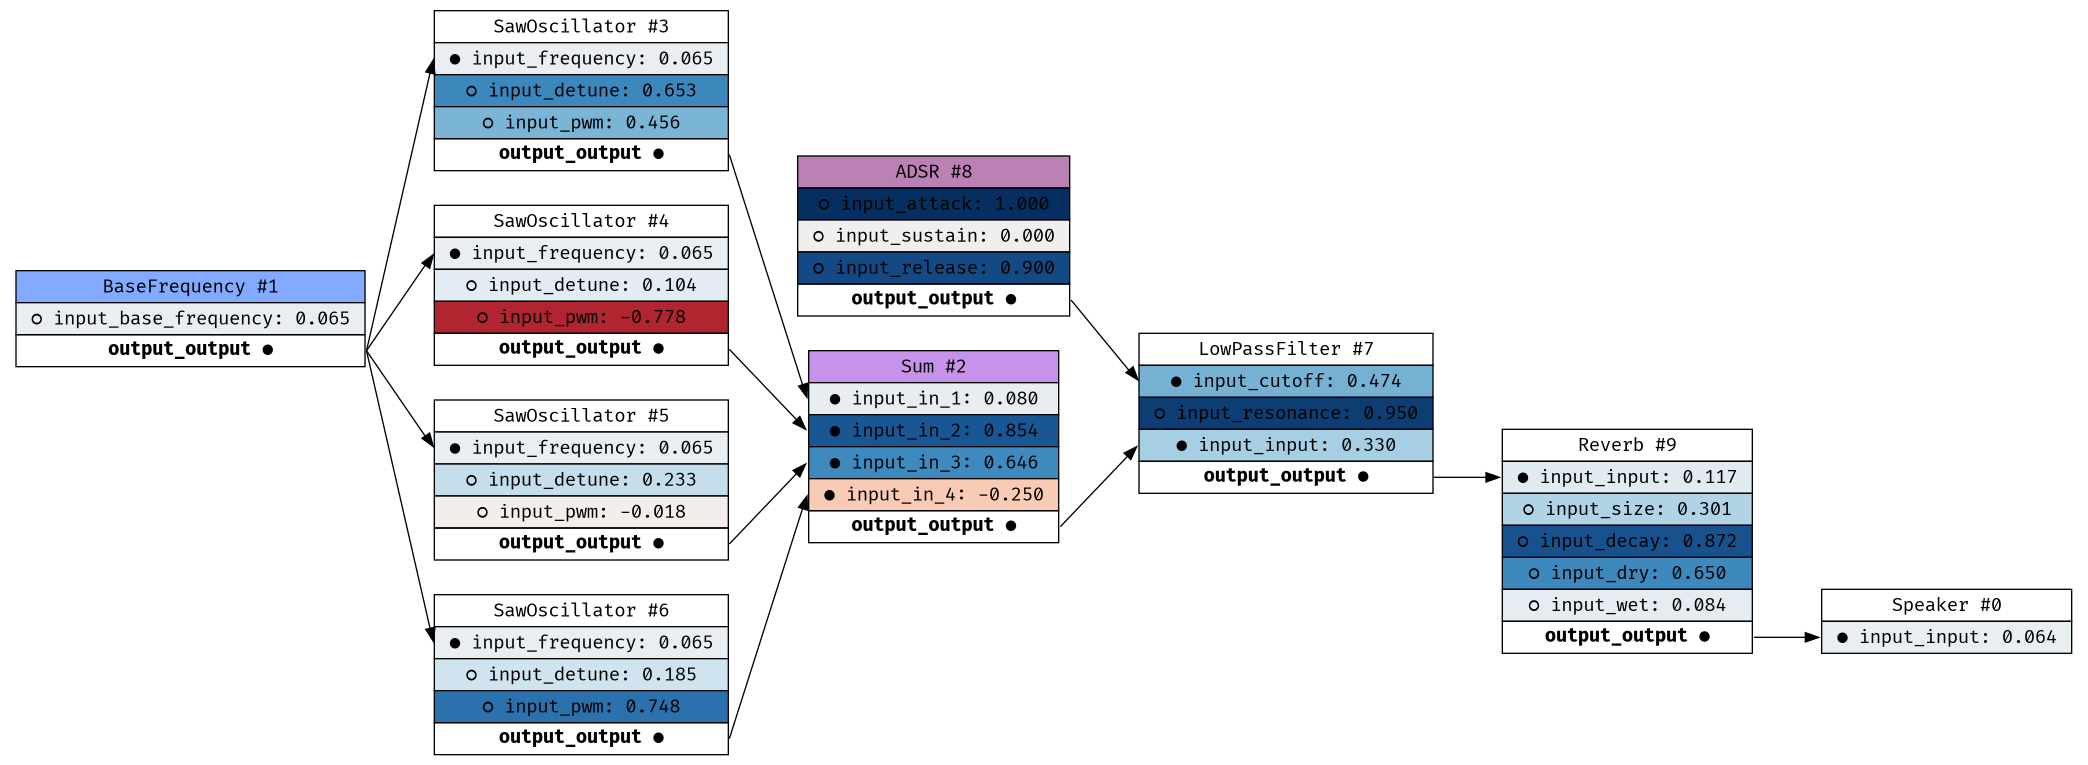

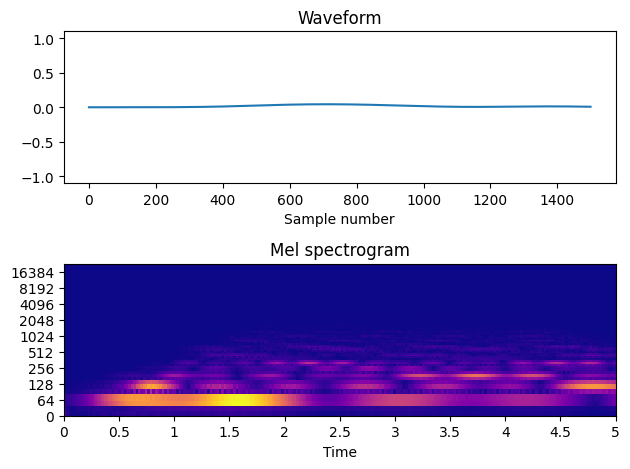

In [3]:
def add_square_with_detune(graph):
    s = SawOscillator()
    # s = SquareOscillator()
    s.input_pwm = 0.3
    s = graph.add_saw(s)
    # s = graph.add_square(s)
    graph.patch(graph.base_frequency_node_id, "output_output", s, "input_frequency")
    
    return s

def fat_analog():
    graph = DspGraph()

    mixer = graph.add_sum(Sum())

    s1 = add_square_with_detune(graph)
    s2 = add_square_with_detune(graph)
    s3 = add_square_with_detune(graph)
    s4 = add_square_with_detune(graph)
    
    graph.patch(s1, "output_output", mixer, "input_in_1")
    graph.patch(s2, "output_output", mixer, "input_in_2")
    graph.patch(s3, "output_output", mixer, "input_in_3")
    graph.patch(s4, "output_output", mixer, "input_in_4")

#     mult = Multiplier()
#     mult.input_scale = 0.3
#     mult = graph.add_multiplier(mult)

    filter_adsr = ADSR()
    f = LowPassFilter()
    f.input_cutoff = 0.6
    f = graph.add_lowpass(f)
    filter_adsr = graph.add_adsr(filter_adsr)
    
    r = Reverb()
    r = graph.add_reverb(r)
    
    graph.patch(filter_adsr, "output_output", f, "input_cutoff")
    graph.set_input(graph.base_frequency_node_id, "input_base_frequency", 0.06541)
    
    # graph.patch(mixer, "output_output", mult, "input_input")
    graph.patch(mixer, "output_output", f, "input_input")
    graph.patch(f, "output_output", r, "input_input")
    graph.patch(r, "output_output", graph.speaker_node_id, "input_input")
    
    return graph

graph = fat_analog()
graph.randomize_inputs()
graph.set_input(7, "input_resonance", 0.95)
graph.set_input(8, "input_attack", 1.0)
graph.set_input(8, "input_sustain", 0.0)
graph.set_input(8, "input_release", 0.9)
audio = Sample(graph.play(SAMPLE_RATE*5))
target_audio = audio
display(Image(graph.draw()))

fig, (ax, ax2) = plt.subplots(2)
audio.plot_waveform(ax, 1500)
audio.plot_spectrogram(ax2)
audio.show_player()
plt.tight_layout()
plt.show()
target_audio = audio

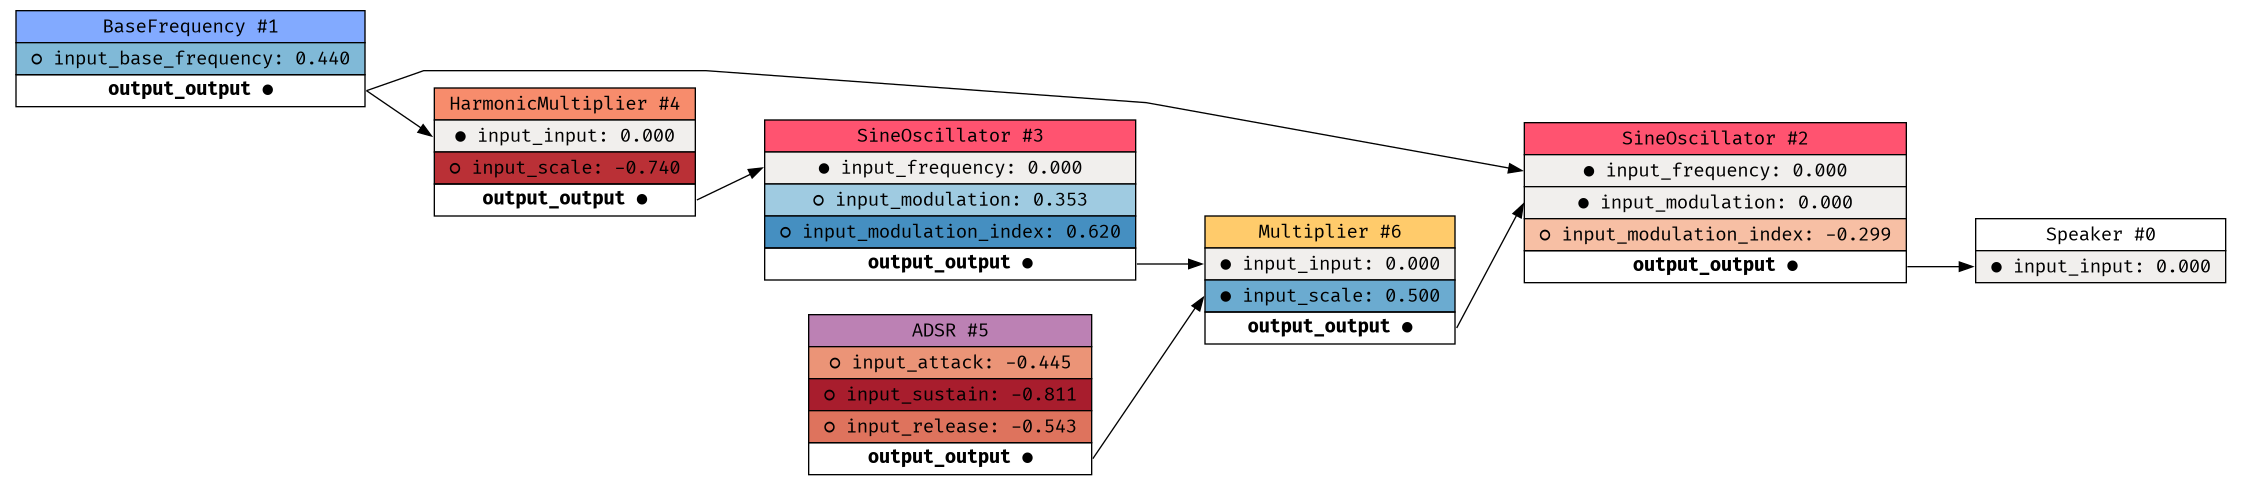

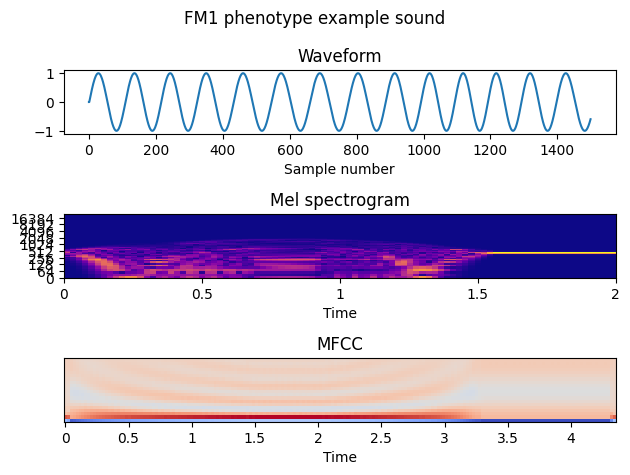

In [4]:
def fm_1(graph: DspGraph):
    """Single operator, single carrier FM"""
    
    carrier = graph.add_sine(SineOscillator())
    modulator = graph.add_sine(SineOscillator())
    
    carrier_multiplier = graph.add_harmonic_multiplier(HarmonicMultiplier())
    
    graph.patch(graph.base_frequency_node_id, "output_output", carrier_multiplier, "input_input")
    graph.patch(carrier_multiplier, "output_output", modulator, "input_frequency")
    graph.patch(graph.base_frequency_node_id, "output_output", carrier, "input_frequency")
    mod_adsr = graph.add_adsr(ADSR())
    mod_strength_multiplier = graph.add_multiplier(Multiplier())
    graph.patch(mod_adsr, "output_output", mod_strength_multiplier, "input_scale")
    graph.patch(modulator, "output_output", mod_strength_multiplier, "input_input")
    graph.patch(mod_strength_multiplier, "output_output", carrier, "input_modulation")
    
    return carrier
    
    
graph = DspGraph()
fm1_source = fm_1(graph)

graph.patch(fm1_source, "output_output", graph.speaker_node_id, "input_input")
graph.randomize_inputs()
# todo: remove
# graph.set_input(2, "input_modulation_index", 0.0)
display(Image(graph.draw()))

audio = Sample(graph.play(SAMPLE_RATE*2))

audio.plot_sound_overview("FM1 phenotype example sound")

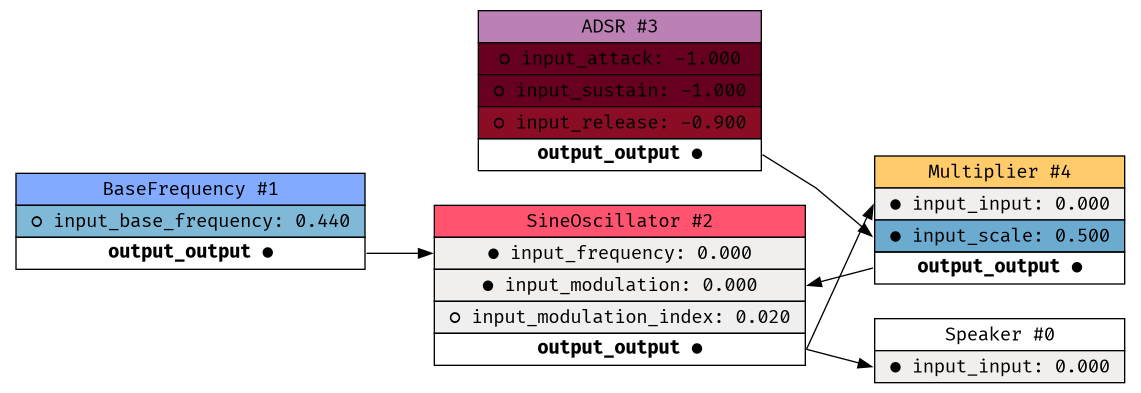

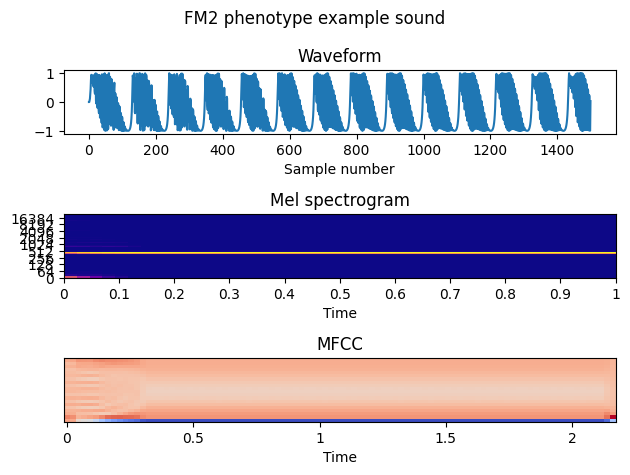

In [5]:
def fm_2(graph: DspGraph):
    """Single operator with feedback"""
    
    carrier = graph.add_sine(SineOscillator())
    graph.patch(graph.base_frequency_node_id, "output_output", carrier, "input_frequency")
    
    mod_adsr = graph.add_adsr(ADSR())
    mod_strength_multiplier = graph.add_multiplier(Multiplier())
    
    graph.patch(mod_adsr, "output_output", mod_strength_multiplier, "input_scale")
    graph.patch(carrier, "output_output", mod_strength_multiplier, "input_input")
    graph.patch(mod_strength_multiplier, "output_output", carrier, "input_modulation")
    
    return carrier
    
    
graph = DspGraph()

fm2_source = fm_2(graph)
graph.patch(fm2_source, "output_output", graph.speaker_node_id, "input_input")
graph.randomize_inputs()

# Cheating to avoid whirling sounds
graph.set_input(3, "input_attack", -1.0)
graph.set_input(3, "input_release", -0.9)
graph.set_input(3, "input_sustain", -1.0)
graph.set_input(2, "input_modulation_index", 0.02)

display(Image(graph.draw()))

audio = Sample(graph.play(SAMPLE_RATE*1))

audio.plot_sound_overview("FM2 phenotype example sound")

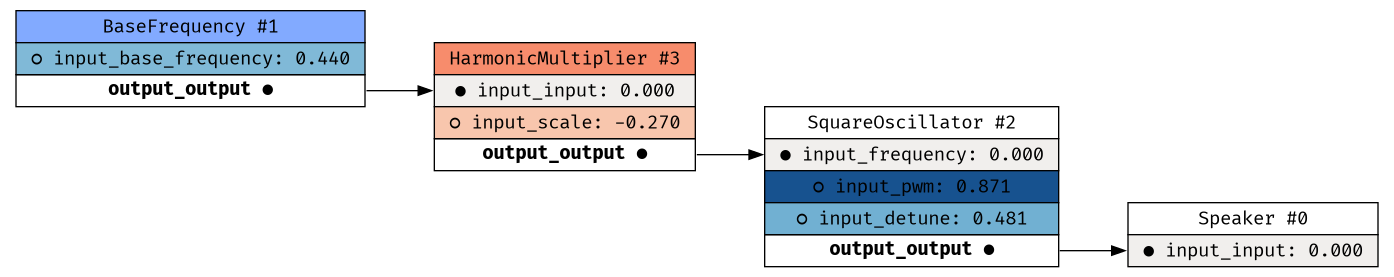

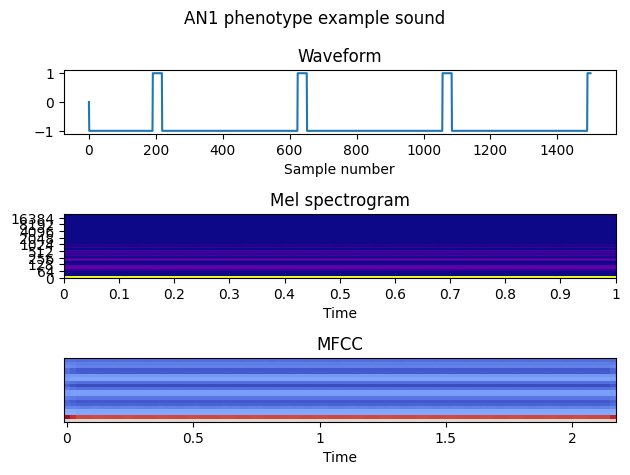

In [6]:
def an_1(graph: DspGraph):
    """Square wave with detune"""
    
    square = graph.add_square(SquareOscillator())
    multiplier = graph.add_harmonic_multiplier(HarmonicMultiplier())
    graph.patch(graph.base_frequency_node_id, "output_output", multiplier, "input_input")
    graph.patch(multiplier, "output_output", square, "input_frequency")
    
    return square
    
    
graph = DspGraph()

an1_source = an_1(graph)
graph.patch(an1_source, "output_output", graph.speaker_node_id, "input_input")
graph.randomize_inputs()

display(Image(graph.draw()))

audio = Sample(graph.play(SAMPLE_RATE*1))

audio.plot_sound_overview("AN1 phenotype example sound")

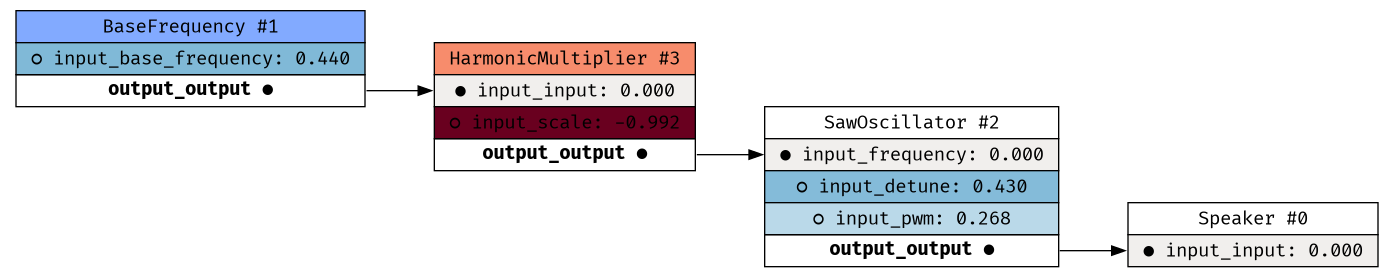

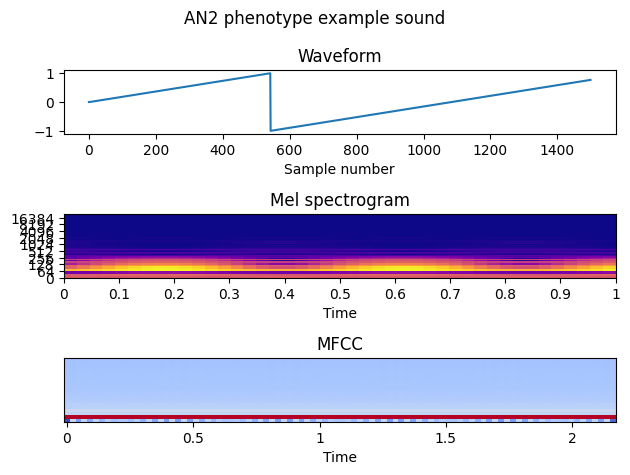

In [7]:
def an_2(graph: DspGraph):
    """Sawtooth wave with detune"""
    
    square = graph.add_saw(SawOscillator())
    multiplier = graph.add_harmonic_multiplier(HarmonicMultiplier())
    graph.patch(graph.base_frequency_node_id, "output_output", multiplier, "input_input")
    graph.patch(multiplier, "output_output", square, "input_frequency")
    
    return square
    
    
graph = DspGraph()

an2_source = an_2(graph)
graph.patch(an2_source, "output_output", graph.speaker_node_id, "input_input")
graph.randomize_inputs()

display(Image(graph.draw()))

audio = Sample(graph.play(SAMPLE_RATE*1))

audio.plot_sound_overview("AN2 phenotype example sound")

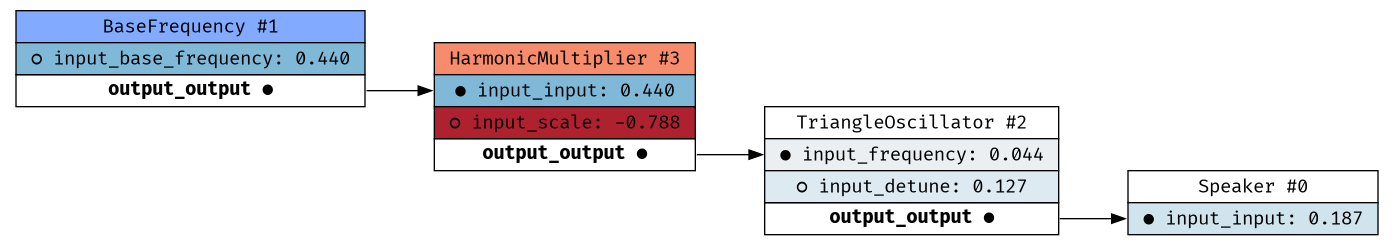

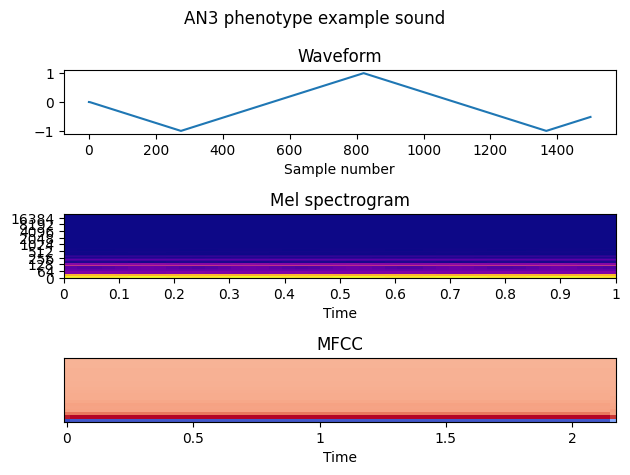

In [8]:
def an_3(graph: DspGraph):
    """Triangle wave with detune"""
    
    triangle = graph.add_triangle(TriangleOscillator())
    multiplier = graph.add_harmonic_multiplier(HarmonicMultiplier())
    graph.patch(graph.base_frequency_node_id, "output_output", multiplier, "input_input")
    graph.patch(multiplier, "output_output", triangle, "input_frequency")
    
    return triangle
    
    
graph = DspGraph()

an2_source = an_3(graph)
graph.patch(an2_source, "output_output", graph.speaker_node_id, "input_input")
graph.randomize_inputs()

audio = Sample(graph.play(SAMPLE_RATE*1))
display(Image(graph.draw()))


audio.plot_sound_overview("AN3 phenotype example sound")

In [9]:
def select_from_array(value: float, array):
    value = ( value + 1.0 ) / 2.0 # Normalise ranging from -1 to 1
    return array[int(value * len(array) - 1.0)]

def make_source(g: DspGraph, source_selector):
    fun = select_from_array(source_selector, [fm_1, fm_2, an_1, an_2, an_3, do_nothing])
    return fun(g)

# def make_source(g: DspGraph, source_selector):
#     fun = select_from_array(source_selector, [fm_1, fm_2, an_1, an_2, an_3, do_nothing])
#     return fun(g)

def make_filter(filter_gene):
    # print("Filter gene", filter_gene)
    return select_from_array(filter_gene, [LowPassFilter(), HighPassFilter(), None])


def do_nothing(g: DspGraph):
    pass

def build_graph_source_section(graph: DspGraph, params):
    mixer = graph.add_sum(Sum())
    
    source_1 = make_source(graph, params[0])
    source_2 = make_source(graph, params[1])
    source_3 = make_source(graph, params[2])
    source_4 = make_source(graph, params[3])
    
    if source_1:
        graph.patch(source_1, "output_output", mixer, "input_in_1")
    if source_2:
        graph.patch(source_2, "output_output", mixer, "input_in_2")
    if source_3:
        graph.patch(source_3, "output_output", mixer, "input_in_3")
    if source_4:
        graph.patch(source_4, "output_output", mixer, "input_in_4")
        
    filter_to_use = make_filter(params[4])
    if filter_to_use:
        if isinstance(filter_to_use, HighPassFilter):
            filter_id = graph.add_highpass(filter_to_use)
        else:
            filter_id = graph.add_lowpass(filter_to_use) 
        
        filter_adsr = graph.add_adsr(ADSR())
        graph.patch(filter_adsr, "output_output", filter_id, "input_cutoff")
        
        graph.patch(mixer, "output_output", filter_id, "input_input")
        return filter_id
    else:
        return mixer

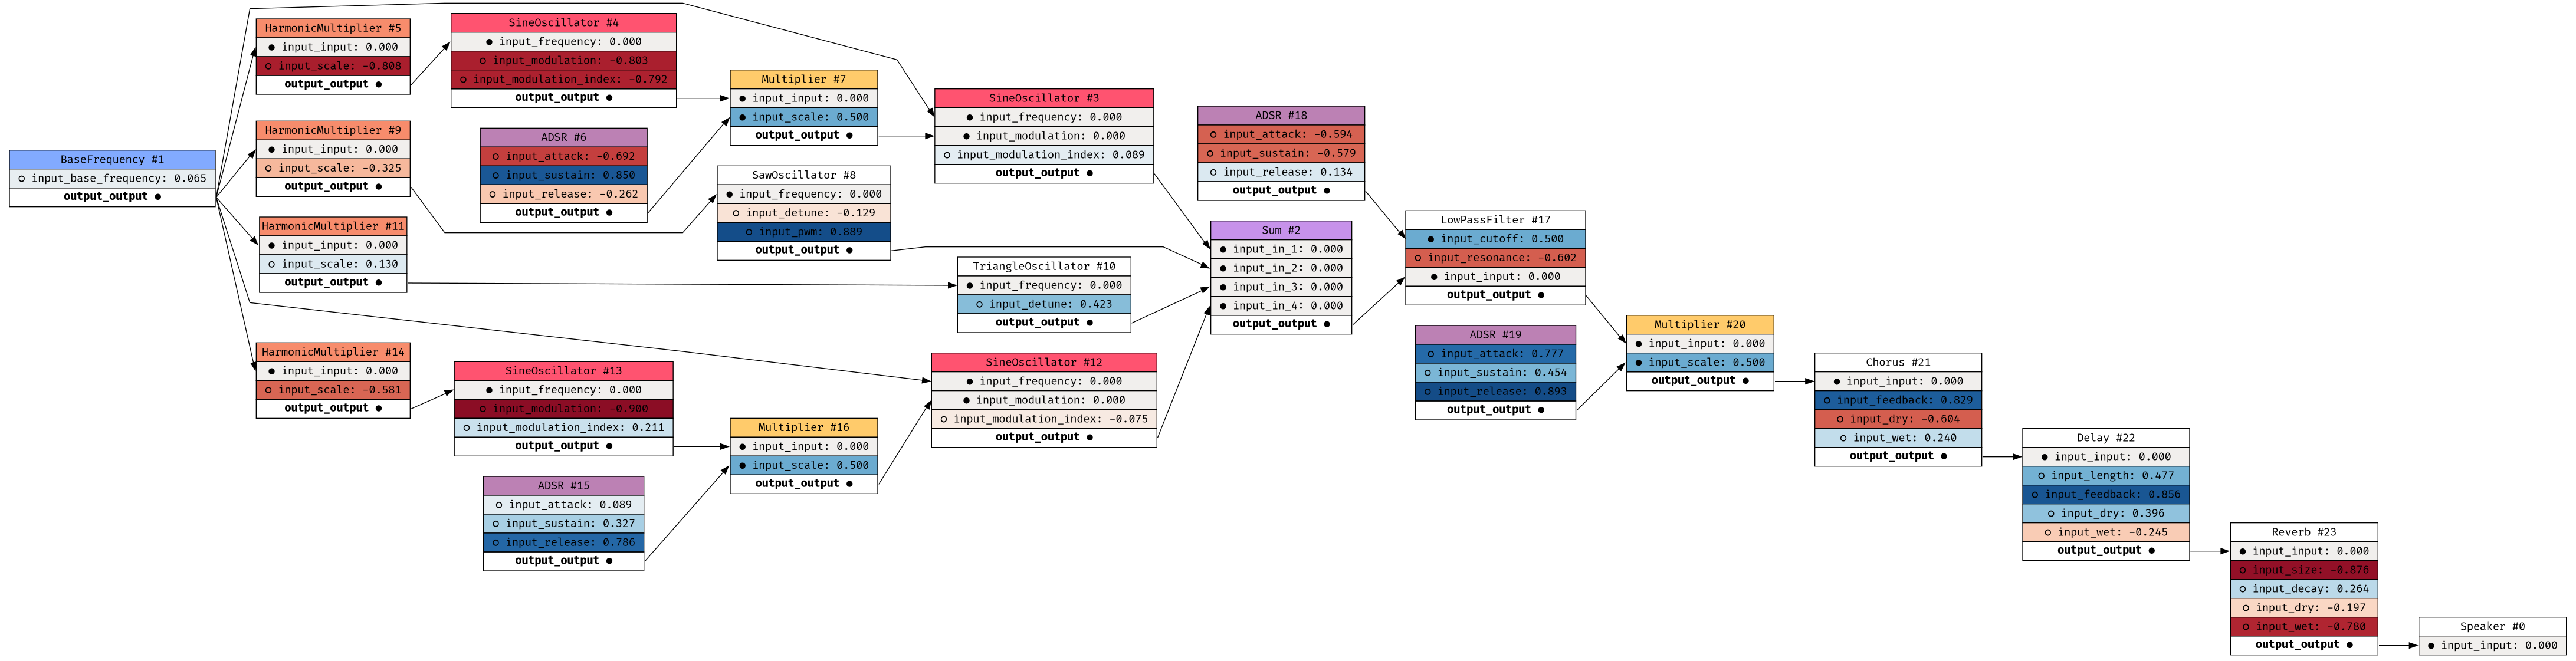

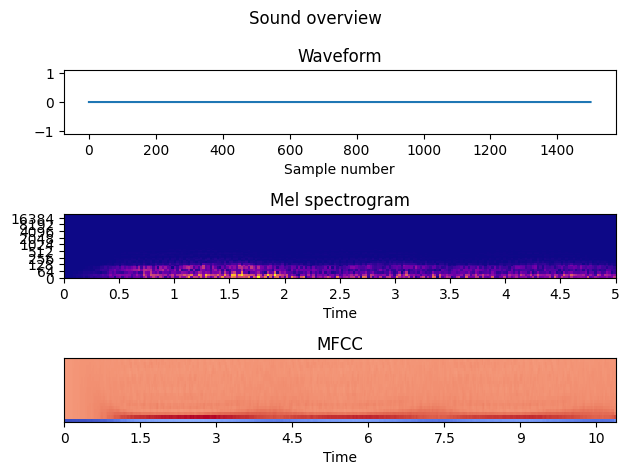

In [10]:
def build_graph_from_params(params):
    graph = DspGraph()
    graph.set_input(graph.base_frequency_node_id, "input_base_frequency", 0.06541)
    
    structure_genotype = params[:10]
    params_genotype = params[10:]

    mixer = build_graph_source_section(graph, structure_genotype)
    amp_adsr = graph.add_adsr(ADSR())
    mixer_amp = graph.add_multiplier(Multiplier())

    graph.patch(amp_adsr, "output_output", mixer_amp, "input_scale")
    graph.patch(mixer, "output_output", mixer_amp, "input_input")
    
    signal_endpoint = mixer_amp

    if params[5] > 0.0:
        chorus = graph.add_chorus(Chorus())
        graph.patch(signal_endpoint, "output_output", chorus, "input_input")
        signal_endpoint = chorus
    
    if params[6] > 0.0:
        delay = graph.add_delay(Delay())
        graph.patch(signal_endpoint, "output_output", delay, "input_input")
        signal_endpoint = delay
    
    if params[7] > 0.0:
        reverb = graph.add_reverb(Reverb())
        graph.patch(signal_endpoint, "output_output", reverb, "input_input")
        signal_endpoint = reverb
        
    graph.patch(signal_endpoint, "output_output", graph.speaker_node_id, "input_input")
    
    graph.set_inputs( params_genotype[:graph.num_inputs()])
    
    return graph


params = np.array([random.uniform(-1, 1) for _ in range(50)])
graph = build_graph_from_params(params)

display(Image(graph.draw()))
audio = Sample(graph.play(SAMPLE_RATE * 5))
audio.plot_sound_overview()

In [11]:
# minilogue_sample_data, minilogue_sample_sr = librosa.load('./RISE.wav', sr=None)
# print("Target sample rate", minilogue_sample_sr)
# print("Generator sample rate", SAMPLE_RATE)

# minilogue_sample = Sample(minilogue_sample_data[:SAMPLE_RATE*7])
# minilogue_sample.plot_sound_overview()

# target_audio = minilogue_sample

Target sample rate 44100
Generator sample rate 48000


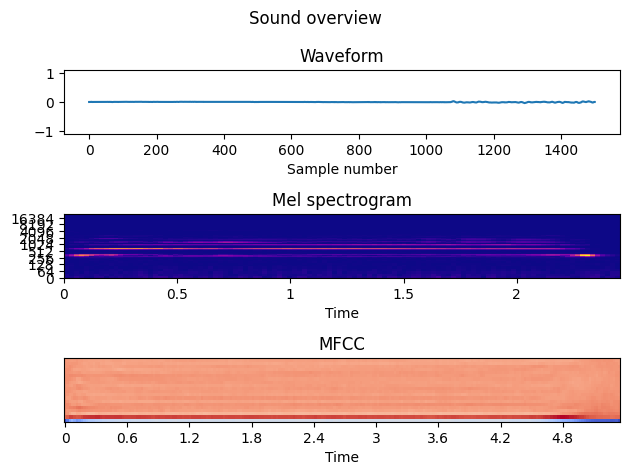

In [12]:
flute_sample_data, flute_sample_rate = librosa.load('./target_flute.wav', sr=None)
print("Target sample rate", flute_sample_rate)
print("Generator sample rate", SAMPLE_RATE)

flute_sample = Sample(flute_sample_data[:SAMPLE_RATE*7])
flute_sample.plot_sound_overview()

337.81917795635553

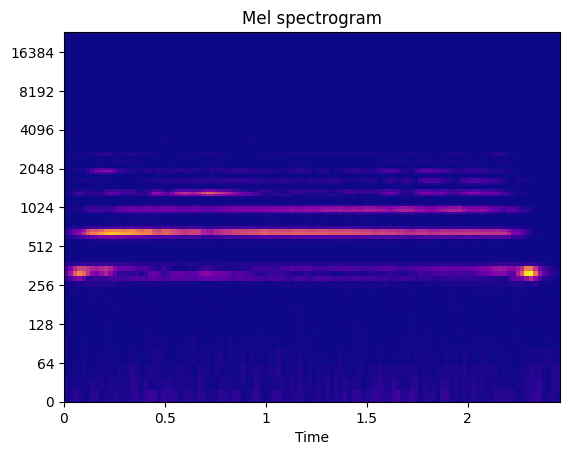

In [17]:
NUM_REPETITIONS = 1
NUM_ITERATIONS = 6
POPULATION_SIZE = 4

fig, ax = plt.subplots()
flute_sample.plot_spectrogram(ax)

f0, voiced_flag, voiced_probs = librosa.pyin(
    y=flute_sample.buffer, sr=SAMPLE_RATE,
    fmin=librosa.note_to_hz('C2'),
    fmax=librosa.note_to_hz('C7')
)

import math

pitches = [ a for a in f0 if not math.isnan(a)]
sum(pitches) / len(pitches)

In [ ]:
flute_sample = Sample(flute_sample.buffer)

def mfcc_dtw_distance(target: Sample, other: Sample):
    return target.mfcc_distance_with_dtw(other)

results = []
for i in range(NUM_REPETITIONS):
    print(i)
    optimizer = DspGraphOptimizer(
        build_graph_from_params,
        mfcc_dtw_distance,
        flute_sample,
        0.337819,
        max_iterations=NUM_ITERATIONS,
        population_size=POPULATION_SIZE,
        workers=-1
    )
    optimizer.optimize()
    results.append(optimizer)

0


In [ ]:
results[0].best_sounds[-1].plot_sound_overview()